<a href="https://colab.research.google.com/github/Muhammadsulton1/ML/blob/main/nlp_Bagwords%2Btf_idf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC,LinearSVC, NuSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, recall_score,precision_score,f1_score,accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
import re
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
#удаление стоп слов
from nltk.corpus import stopwords
nltk.download('stopwords')
#стемминг 
from nltk.stem import SnowballStemmer
import unicodedata
#лемитизация
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [2]:
from xgboost import XGBClassifier

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
train.isna().sum() / train.shape[0]

id          0.000000
keyword     0.008013
location    0.332720
text        0.000000
target      0.000000
dtype: float64

In [7]:
test.isna().sum()/ test.shape[0]

id          0.000000
keyword     0.007968
location    0.338645
text        0.000000
dtype: float64

In [8]:
train[~train['keyword'].isna()]

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0
...,...,...,...,...,...
7578,10830,wrecked,NaN,@jt_ruff23 @cameronhacker and I wrecked you both,0
7579,10831,wrecked,"Vancouver, Canada",Three days off from work and they've pretty mu...,0
7580,10832,wrecked,London,#FX #forex #trading Cramer: Iger's 3 words tha...,0
7581,10833,wrecked,Lincoln,@engineshed Great atmosphere at the British Li...,0


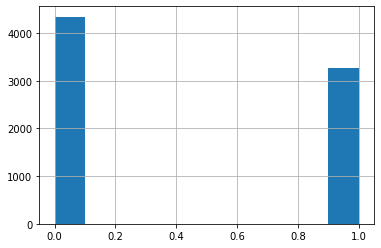

In [9]:
train['target'].hist()

In [10]:
train.describe(include='object')

,keyword,location,text
count,7552,5080,7613
unique,221,3341,7503
top,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...
freq,45,104,10


In [11]:
train.drop('location',axis=1, inplace=True)
test.drop('location',axis=1, inplace=True)

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       7613 non-null   int64 
 1   keyword  7552 non-null   object
 2   text     7613 non-null   object
 3   target   7613 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 238.0+ KB


In [13]:
train_keyword = train['keyword'].mode()
test_keyword = test['keyword'].mode()

In [14]:
print(train_keyword)
print(test_keyword)

0    fatalities
dtype: object
0    deluged
dtype: object


In [15]:
train.fillna('fatalities', inplace=True)
test.fillna('deluged',inplace=True)

In [16]:
data = pd.concat([train, test]).reset_index(drop=True)

In [17]:
data.head()

,id,keyword,text,target
0,1,fatalities,Our Deeds are the Reason of this #earthquake M...,1.0
1,4,fatalities,Forest fire near La Ronge Sask. Canada,1.0
2,5,fatalities,All residents asked to 'shelter in place' are ...,1.0
3,6,fatalities,"13,000 people receive #wildfires evacuation or...",1.0
4,7,fatalities,Just got sent this photo from Ruby #Alaska as ...,1.0


In [18]:
#применим функцию к нижниму регистру
def capitalizer(string: str) -> str:
    return string.lower()
# Применить функцию
data['text'] = [capitalizer(string) for string in data['text']]

In [19]:
#поменяем точки в тексте на ничего
def change_point(x):
  return x.replace('.','')
data['text'] = [change_point(string) for string in data['text']]

In [20]:
#поменяем запятые в тексте на ничего
def change_coma(x):
  return x.replace(',','')
data['text'] = [change_point(string) for string in data['text']]

In [21]:
def remove_emails(x):
     return re.sub(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+)',"", x)

In [22]:
def remove_urls(x):
    return re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '' , x)

In [23]:
def remove_rt(x):
    return re.sub(r'\brt\b', '', x).strip()

In [24]:
def remove_special_chars(x):
    x = re.sub(r'[^\w ]+', "", x)
    x = ' '.join(x.split())
    return x

In [25]:
def remove_accented_chars(x):
    x = unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return x

In [26]:
def remove_numbers(s, keep=None):
    if keep:
        keep = set(str(x) for x in keep)
        return re.sub(r'\b\d+\b', lambda m: m.group() if m.group() in keep else '', s)
    else:
        # Shortcircuit the use of a set if there is no sequence to keep
        return re.sub(r'\b\d+\b', '', s)

In [27]:
data['text_clean'] = data['text'].apply(lambda x: remove_emails(x))
data['text_clean'] = data['text_clean'].apply(lambda x: remove_urls(x))
data['text_clean'] = data['text_clean'].apply(lambda x: remove_rt(x))
data['text_clean'] = data['text_clean'].apply(lambda x: remove_special_chars(x))
data['text_clean'] = data['text_clean'].apply(lambda x: remove_accented_chars(x))
data['text_clean'] = data['text_clean'].apply(lambda x: remove_numbers(x))

In [28]:
data.head()

,id,keyword,text,target,text_clean
0,1,fatalities,our deeds are the reason of this #earthquake m...,1.0,our deeds are the reason of this earthquake ma...
1,4,fatalities,forest fire near la ronge sask canada,1.0,forest fire near la ronge sask canada
2,5,fatalities,all residents asked to 'shelter in place' are ...,1.0,all residents asked to shelter in place are be...
3,6,fatalities,"13,000 people receive #wildfires evacuation or...",1.0,people receive wildfires evacuation orders in...
4,7,fatalities,just got sent this photo from ruby #alaska as ...,1.0,just got sent this photo from ruby alaska as s...


In [29]:
#УДАЛИТЬ ПРОБЕЛЫ
data['text_clean'] = [string.strip() for string in data['text_clean']]

In [30]:
data.head(3)

,id,keyword,text,target,text_clean
0,1,fatalities,our deeds are the reason of this #earthquake m...,1.0,our deeds are the reason of this earthquake ma...
1,4,fatalities,forest fire near la ronge sask canada,1.0,forest fire near la ronge sask canada
2,5,fatalities,all residents asked to 'shelter in place' are ...,1.0,all residents asked to shelter in place are be...


In [31]:
#токенизация текста
data = data.assign(text_tokenize = data['text_clean'].apply(word_tokenize))

In [32]:
#удаление стоп-слов
stop_words = stopwords.words('english')
data['text_tokenize'] = data['text_tokenize'].apply(lambda x: [item for item in x if item not in stop_words])

In [33]:
df = data.copy()

In [34]:
data.head()

,id,keyword,text,target,text_clean,text_tokenize
0,1,fatalities,our deeds are the reason of this #earthquake m...,1.0,our deeds are the reason of this earthquake ma...,"[deeds, reason, earthquake, may, allah, forgiv..."
1,4,fatalities,forest fire near la ronge sask canada,1.0,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]"
2,5,fatalities,all residents asked to 'shelter in place' are ...,1.0,all residents asked to shelter in place are be...,"[residents, asked, shelter, place, notified, o..."
3,6,fatalities,"13,000 people receive #wildfires evacuation or...",1.0,people receive wildfires evacuation orders in ...,"[people, receive, wildfires, evacuation, order..."
4,7,fatalities,just got sent this photo from ruby #alaska as ...,1.0,just got sent this photo from ruby alaska as s...,"[got, sent, photo, ruby, alaska, smoke, wildfi..."


In [35]:
#лематизация текста
lemmatizer = WordNetLemmatizer()
data['text_tokenize'] = data['text_tokenize'].apply(lambda x: [lemmatizer.lemmatize(y, pos='v') for y in x])

In [36]:
#стемминг 
snowball = SnowballStemmer("english")
df['text_tokenize'] = df['text_tokenize'].apply(lambda x: [snowball.stem(y) for y in x])

In [37]:
data = data.assign(text_str = data['text_tokenize'].apply(str))

In [38]:
df = df.assign(text_str = df['text_tokenize'].apply(str))

In [39]:
data.head()

,id,keyword,text,target,text_clean,text_tokenize,text_str
0,1,fatalities,our deeds are the reason of this #earthquake m...,1.0,our deeds are the reason of this earthquake ma...,"[deeds, reason, earthquake, may, allah, forgiv...","['deeds', 'reason', 'earthquake', 'may', 'alla..."
1,4,fatalities,forest fire near la ronge sask canada,1.0,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]","['forest', 'fire', 'near', 'la', 'ronge', 'sas..."
2,5,fatalities,all residents asked to 'shelter in place' are ...,1.0,all residents asked to shelter in place are be...,"[residents, ask, shelter, place, notify, offic...","['residents', 'ask', 'shelter', 'place', 'noti..."
3,6,fatalities,"13,000 people receive #wildfires evacuation or...",1.0,people receive wildfires evacuation orders in ...,"[people, receive, wildfires, evacuation, order...","['people', 'receive', 'wildfires', 'evacuation..."
4,7,fatalities,just got sent this photo from ruby #alaska as ...,1.0,just got sent this photo from ruby alaska as s...,"[get, send, photo, ruby, alaska, smoke, wildfi...","['get', 'send', 'photo', 'ruby', 'alaska', 'sm..."


In [40]:
data.drop(['text','text_clean','text_tokenize'], axis=1, inplace=True)
df.drop(['text','text_clean','text_tokenize'], axis=1, inplace=True)

In [41]:
data.head()

,id,keyword,target,text_str
0,1,fatalities,1.0,"['deeds', 'reason', 'earthquake', 'may', 'alla..."
1,4,fatalities,1.0,"['forest', 'fire', 'near', 'la', 'ronge', 'sas..."
2,5,fatalities,1.0,"['residents', 'ask', 'shelter', 'place', 'noti..."
3,6,fatalities,1.0,"['people', 'receive', 'wildfires', 'evacuation..."
4,7,fatalities,1.0,"['get', 'send', 'photo', 'ruby', 'alaska', 'sm..."


In [42]:
def Vectorize_text(text, max_features=250, ngram_range=(1, 2), min_df=1):
    X_vect = list(text)
    tfidf = TfidfVectorizer(min_df=min_df, ngram_range=ngram_range, max_features=max_features)
    #X_vect = tfidf.fit_transform(text).toarray() 
    X_vect = pd.DataFrame(tfidf.fit_transform(X_vect).toarray(), index=text.index)      
    return X_vect

In [43]:
tfidf_features = Vectorize_text(data['text_str'])

In [44]:
count_vectorizer = CountVectorizer(min_df=1, ngram_range=(1,1))
count_features = count_vectorizer.fit_transform(data['text_str'])
count_svd = TruncatedSVD(n_components=100, n_iter=5, random_state=10)
count_bow = count_svd.fit_transform(count_features)
df_bow_col_name = ["bow_"+str(i) for i in range(100)]
df_bow = pd.DataFrame(count_bow)
df_bow.columns = df_bow_col_name

In [45]:
svd = TruncatedSVD(n_components=100, n_iter=5, random_state=0)
truncated_tfidf = svd.fit_transform(tfidf_features)
df_tfidf_col_name = ["tfidf_"+str(i) for i in range(100)]
df_tfidf = pd.DataFrame(truncated_tfidf)
df_tfidf.columns = df_tfidf_col_name

In [46]:
df_tfidf[:4]

,tfidf_0,tfidf_1,tfidf_2,tfidf_3,tfidf_4,tfidf_5,tfidf_6,tfidf_7,tfidf_8,tfidf_9,...,tfidf_90,tfidf_91,tfidf_92,tfidf_93,tfidf_94,tfidf_95,tfidf_96,tfidf_97,tfidf_98,tfidf_99
0,0.061237,-0.028024,-0.009988,0.046420,0.012095,0.029718,-0.017223,0.019080,0.040411,0.037844,...,0.044100,-0.009376,-0.167929,0.000501,0.019817,0.027088,0.027274,-0.052059,-0.083687,0.095485
1,0.163564,-0.337984,0.339448,-0.105789,-0.044167,-0.078009,-0.028331,-0.016398,-0.039411,-0.026250,...,0.048170,0.010529,0.022830,-0.069808,-0.039167,-0.059562,0.054067,0.017794,-0.039680,-0.054776
2,0.019847,-0.025754,0.020672,0.016938,-0.001395,-0.014499,0.003630,0.009677,-0.005516,0.011788,...,0.098396,-0.006174,0.046526,0.057452,-0.018884,-0.013897,-0.041308,0.039429,-0.031596,0.047576
3,0.084473,-0.082191,0.027379,0.036012,0.019102,-0.022717,-0.056668,-0.008507,0.036351,0.074487,...,0.055093,0.017774,0.038482,0.088773,-0.032341,-0.026574,-0.031969,0.030802,-0.029057,0.004469


In [47]:
df_bow[:4]

,bow_0,bow_1,bow_2,bow_3,bow_4,bow_5,bow_6,bow_7,bow_8,bow_9,...,bow_90,bow_91,bow_92,bow_93,bow_94,bow_95,bow_96,bow_97,bow_98,bow_99
0,0.123662,0.067911,0.032462,-0.007403,-0.142306,-0.066067,-0.086272,-0.016398,0.049205,-0.188592,...,-0.025423,0.041834,-0.066448,-0.007935,-0.130598,-0.039342,-0.101573,-0.007488,0.047403,0.072552
1,0.356818,0.805452,-0.358461,-0.334549,0.386359,-0.009204,-0.039098,0.071600,-0.000028,-0.060215,...,-0.024714,-0.018209,-0.018001,0.068646,-0.014493,0.050821,-0.103540,-0.083844,0.081073,0.183852
2,0.085208,0.048705,0.029044,-0.013427,-0.065296,0.030108,-0.067819,-0.046888,-0.081460,-0.018109,...,-0.002515,-0.076630,-0.056286,0.050450,-0.115455,-0.023486,-0.057501,0.087825,0.023207,0.102021
3,0.162970,0.160558,0.035157,-0.068193,-0.066375,0.075123,-0.187815,-0.120124,-0.062130,0.035287,...,-0.008429,0.086992,-0.119254,-0.050667,-0.098967,-0.012363,-0.072634,0.015822,-0.013766,0.033529


In [48]:
data = pd.get_dummies(data, columns=['keyword'], drop_first=True)

In [49]:
data = data.join(df_tfidf)
data = data.join(df_bow)

In [50]:
data.drop(['text_str'], axis=1, inplace=True)

In [51]:
new_data = data[:train.shape[0]]

In [52]:
new_data.head()

,id,target,keyword_accident,keyword_aftershock,keyword_airplane%20accident,keyword_ambulance,keyword_annihilated,keyword_annihilation,keyword_apocalypse,keyword_armageddon,...,bow_90,bow_91,bow_92,bow_93,bow_94,bow_95,bow_96,bow_97,bow_98,bow_99
0,1,1.0,0,0,0,0,0,0,0,0,...,-0.025423,0.041834,-0.066448,-0.007935,-0.130598,-0.039342,-0.101573,-0.007488,0.047403,0.072552
1,4,1.0,0,0,0,0,0,0,0,0,...,-0.024714,-0.018209,-0.018001,0.068646,-0.014493,0.050821,-0.103540,-0.083844,0.081073,0.183852
2,5,1.0,0,0,0,0,0,0,0,0,...,-0.002515,-0.076630,-0.056286,0.050450,-0.115455,-0.023486,-0.057501,0.087825,0.023207,0.102021
3,6,1.0,0,0,0,0,0,0,0,0,...,-0.008429,0.086992,-0.119254,-0.050667,-0.098967,-0.012363,-0.072634,0.015822,-0.013766,0.033529
4,7,1.0,0,0,0,0,0,0,0,0,...,-0.015184,-0.067755,-0.018360,0.066614,-0.012676,0.020637,0.094724,-0.056188,0.033995,-0.084696


In [53]:
#df_train = data.iloc[:train.shape[0]]
X = new_data.drop(['target','id'],axis=1)
y = new_data['target']

In [54]:
df_test = data.iloc[train.shape[0]:]
#X_test = df_test.iloc[:,4:]

In [55]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.25, random_state=17)

In [75]:
models = [LogisticRegression(), GaussianNB(), RandomForestClassifier(), BernoulliNB(), 
          DecisionTreeClassifier(),SVC(), LinearSVC(),NuSVC(), XGBClassifier()]
score = []
for classifier in models:
  pipe = Pipeline(steps=[('scaler', StandardScaler()),
                      ('classifier', classifier)])
  pipe.fit(X_train, y_train) 
  score.append({'classifier_name':classifier, 
  'recall_score':recall_score(y_test,pipe.predict(X_test)),
  'precision_score':precision_score(y_test,pipe.predict(X_test)),
  'f1_score':f1_score(y_test,pipe.predict(X_test)),
  'accuracy_score':accuracy_score(y_test,pipe.predict(X_test))})

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [76]:
score_models = pd.DataFrame(score)

In [80]:
score_models.sort_values(by=['f1_score'], ascending=False)

,classifier_name,recall_score,precision_score,f1_score,accuracy_score
6,LinearSVC(),0.727932,0.750623,0.739104,0.776786
0,LogisticRegression(),0.701330,0.775401,0.736508,0.782038
7,NuSVC(),0.678356,0.801429,0.734774,0.787290
5,SVC(),0.669891,0.797122,0.727989,0.782563
1,GaussianNB(),0.775091,0.662190,0.714206,0.730567
8,XGBClassifier(),0.637243,0.784226,0.703135,0.766282
2,"(DecisionTreeClassifier(max_features='auto', r...",0.636034,0.781575,0.701333,0.764706
3,BernoulliNB(),0.681983,0.675449,0.678700,0.719538
4,DecisionTreeClassifier(),0.640871,0.648715,0.644769,0.693277
